# Efficient Online Learning of Contact Force Models for Connector Insertion *MuJoCo Demo*
**This colab accompanies our paper, available at [model-based-plugging.github.io](model-based-plugging.github.io).**

In this colab we use a simple toy connector insertion environment in MuJoCo to demonstrate the simplicity and effectiveness of the ideas proposed in our paper. This colab will work through the following main points of the paper:


*   The contact forces on the connector during insertion can be modeled with a simple linear function.
*   An estimate of this linear function can be solved for online with a novel Linear Model Learning (LML) algorithm.
*   A convex optimization control policy can use this linear model to guide the connector to a smooth insertion.


In [2]:
#%%capture

# @title Install MuJoCo
!pip install mujoco
#@title Check if installation was successful

# from google.colab import files

import distutils.util
import os
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# Torch setup
import torch
from torch import nn, zeros
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import random
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.
Installing mediapy:
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
Using device: cuda


In [13]:
# @title Load simple connector MJCF as `xml`
xml ="""
<mujoco>
  <default>
    <geom density="1" solimp="0.0 0.1 0.1 0.5 2"/>
    <!-- <geom solimp="0.0 0.1 0.1 0.5 2" /> -->
  </default>

  <visual>
    <map force="0.1"/>
    <headlight ambient="0.7 0.7 0.7"/>
    <rgba contactforce="0.7 1.0 1.0 .6"/>
  </visual>

  <visual>
  <global offwidth="1024" offheight="1024"/>
  <rgba haze="0.15 0.25 0.35 1"/>
</visual>


  <option>
    <flag gravity="disable"/>
  </option>


<asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0."/>
  </asset>

  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <geom name="floor" pos="0 0 -0.1" size="0 0 0.05" type="plane" material="grid"/>
    <light name="spotlight" mode="targetbodycom" target="m" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>

    <body name="m" pos="0 0 3">
      <joint type="slide" name="pos_x" axis="1 0 0"/>
      <joint type="slide" name="pos_y" axis="0 1 0"/>
      <joint type="slide" name="pos_z" axis="0 0 1"/>
    <geom name="male" type="box" size = ".45 .4 1.0" rgba=".4 .2 .1 .5" />
      <body name = "mb1" >
        <geom name="mb1" size=".085" pos="0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb2" >
        <geom name="mb2" size=".085" pos="-0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb3" >
        <geom name="mb3" size=".085" pos=".45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb4" >
        <geom name="mb4" size=".085" pos="-.45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <camera name="track" pos="0 -6 0" xyaxes="1 0 0 0 .2 1" mode="track"/>
      <site name="FT"/>
    </body>
  </worldbody>

  <default>
    <general ctrlrange="-1 1" ctrllimited="true" biastype="affine"/>
  </default>

  <actuator>
    <general name="pos_x" joint="pos_x" gainprm="10" biasprm="0 0 -10"/>
    <general name="pos_y" joint="pos_y" gainprm="10" biasprm="0 0 -10"/>
    <general name="pos_z" joint="pos_z" gainprm="10" biasprm="0 0 -10"/>
  </actuator>

  <sensor>
    <jointpos name="px" joint="pos_x"/>
    <jointpos name="py" joint="pos_y"/>
    <jointpos name="pz" joint="pos_z"/>
  </sensor>

</mujoco>
"""

In [14]:
# Environment Setup as a custom gym environment
from typing import Optional
import numpy as np
import gymnasium as gym
from scipy.spatial.transform import Rotation

class PluggingEnv(gym.Env):
    def __init__(self, xml):
        # make model and data
        self.model = mujoco.MjModel.from_xml_string(xml)
        self.data = mujoco.MjData(self.model)
        self.n_steps_per_call = 10
        dt = 1/600
        self.model.opt.timestep = dt/self.n_steps_per_call
        self.observation_space = gym.spaces.Box(low=-40, high=40, shape=(6,))
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(3,))
        self.max_steps = 30
        self.step_count = 0

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.model = mujoco.MjModel.from_xml_string(xml)
        self.data = mujoco.MjData(self.model)
        self.step_count = 0
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos = np.random.rand(3) * 1 - 0.5
        self.data.qvel = np.zeros((3,))
        obs, _, _, _, info = self.step([0, 0, 0])
        return obs, info

    def _get_obs(self):
        obs_arr = np.concatenate((
        self.data.qpos.copy(),
        self.data.qvel.copy()
        ))
        return obs_arr

    def _get_reward(self, state, action):
        k_pos = 1
        k_force = 1
        return -np.linalg.norm(state)**2

    def step(self, action):
        self.data.ctrl = np.clip(action, -3, 3)
        mujoco.mj_step(self.model, self.data, nstep = self.n_steps_per_call)
        observation = self._get_obs()
        reward = self._get_reward(observation, action)
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        #if terminated:
            #print(reward)
        truncated = np.linalg.norm(observation[0:3]) > 4
        info = dict()
        return observation, reward, terminated, truncated, info
        

# make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# make renderer, render and show the pixels
renderer = mujoco.Renderer(model, width=1000, height=1000)
options = mujoco.MjvOption()

# turn on contact force visualizer
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# Shoving a misaligned connector

Let's see what happens when we try to force a connector that is slightly misaligned. We will use the contact force visualization in MuJoCo to get an idea of where the contact forces are coming from.

In [15]:
from stable_baselines3 import PPO
import tensorflow as tf

env = PluggingEnv(xml)
learn_model = PPO("MlpPolicy", env, device="cpu", verbose=1, learning_rate=0.003, batch_size=256, gamma=0.9, gae_lambda=0.8)
learn_model.learn(total_timesteps=250_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29       |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    fps             | 2811     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -9.75       |
| time/                   |             |
|    fps                  | 2481        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015441512 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss   

-0.5149929335304397
-0.6635229076340626
-0.47776433725105
-0.8139811508699122
-0.43843934346729474
-0.7378715793643702
-0.8341698197394619
-0.36521216934722184
-0.5748798791100913
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.3       |
| time/                   |             |
|    fps                  | 1886        |
|    iterations           | 8           |
|    time_elapsed         | 8           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.010037225 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.52       |
|    explained_variance   | -0.00994    |
|    learning_rate        | 0.003       |
|    loss                 | 0.423       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00789    |
|    std              

-0.5722680116690553
-0.7139850322315632
-0.5199641768725778
-0.4888560981080347
-0.26915371071736094
-0.7147111613163547
-0.3179023998203153
-0.3232965104083153
-0.23219445077635306
-0.276371483351089
-0.7992916070318351
-0.4803985137235086
-0.4828201884074024
-0.9342598892685876
-0.8828563770840511
-0.4904703777278557
-0.5171877416981505
-0.6518951239236881
-0.13672797674017534
-0.45105447636828183
-0.50580021811518
-0.49087219310007657
-0.5636879261110047
-0.5994550874925975
-0.25869868459854745
-0.6773792018909264
-0.6142822646321512
-0.532129097732713
-0.5794698925156169
-0.4716103519970547
-0.5732037417439149
-0.49631425479785485
-0.8571755579127545
-0.4267551151315276
-0.7215686286319899
-0.2616172299125365
-0.5425830855674404
-0.8268887094781948
-0.32564768515471837
-0.4779110410729594
-0.34672524237884733
-0.4556005199774113
-0.38709363942526753
-0.2675579489120392
-0.5297150985270567
-0.656723027427278
-0.6424398629776052
-0.47893141154255015
-0.44630149686710385
-0.3645093562

-0.16820855545671903
-0.6030464068313741
-0.7704392964437263
-0.6347779872616374
-0.7295078242797708
-0.7439307150733597
-0.6304675749234682
-0.8099710064484104
-0.5340349684010776
-0.2005123773210308
-0.7881007229510985
-0.492396208096714
-0.19807302254483505
-0.6430549787440307
-0.09337333129842125
-0.648904561256785
-0.4899434745359576
-0.5181477143196055
-0.9326351308636799
-0.5445565537557264
-0.3935943250812199
-0.5436846943439615
-0.3359206997186422
-0.2689480444433637
-0.5439009688949228
-0.6213571509069635
-0.1769182478965157
-0.34146551648982393
-0.7896333747033314
-0.602790900689911
-0.7031849817923067
-0.8157475215910793
-0.5378100689649138
-0.30749977691011543
-0.37585134850429
-0.650024821664146
-0.7544075602674405
-0.4208817882865936
-0.5034075030565662
-0.635200888174693
-0.3408180227151432
-0.2759362892708762
-0.47432594404425893
-0.7587874437141398
-0.4896407921075208
-0.7973964027944677
-0.6232596352650525
-0.6158067868543727
-0.36965175736246125
-0.6815835875889227


-0.9203898100645421
-0.45519584070342534
-0.7090339946195493
-0.5311980165465431
-0.6085539545103346
-0.4463595648407061
-0.22800731940363672
-0.5693342516577226
-0.3692077775073736
-0.5824911384436993
-0.43267519125838555
-0.6031706703388915
-0.20899954770856555
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -13.6       |
| time/                   |             |
|    fps                  | 1804        |
|    iterations           | 19          |
|    time_elapsed         | 21          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.013686116 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.32       |
|    explained_variance   | 0.394       |
|    learning_rate        | 0.003       |
|    loss                 | 0.6         |
|    n_updates        

-0.4563724787749994
-0.19785082572273963
-0.2984588577173866
-0.5707030691926768
-0.26094641820801534
-0.3659188588930586
-0.716022376724772
-0.8337642048515586
-0.33610572409425765
-0.19408996925915586
-0.4291744854733978
-0.3589258979374299
-0.496485479274097
-0.6405807739722368
-0.40949797702154556
-0.3865690305332444
-0.41945189983109177
-0.5736180675078055
-0.3107622342102528
-0.6043802244594169
-0.6050294906043425
-0.5849682321843349
-0.4052153906469002
-0.5689733992214475
-0.5113739559751398
-0.5128245874245466
-0.3799172698172607
-0.7604364442310507
-0.40413831612596973
-0.4770576984028245
-0.48576259345320044
-0.6538320804631775
-0.7291098314092858
-0.42235329527299065
-0.5461443660033972
-0.36271654467050773
-0.34811261063199617
-0.31340780919394756
-0.46796385424452985
-0.371730943302544
-0.30424939424257036
-0.6417586220254711
-0.6373300859957401
-0.47577138013810144
-0.8100477309343844
-0.5281776971486055
-0.8150128450483134
-0.5445293723037258
-0.41955153771501674
-0.1873

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29           |
|    ep_rew_mean          | -13.8        |
| time/                   |              |
|    fps                  | 1806         |
|    iterations           | 26           |
|    time_elapsed         | 29           |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0106496755 |
|    clip_fraction        | 0.143        |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.14        |
|    explained_variance   | 0.55         |
|    learning_rate        | 0.003        |
|    loss                 | 0.483        |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00943     |
|    std                  | 0.937        |
|    value_loss           | 0.899        |
------------------------------------------
-0.30261456599074693
-0.5701469315937555
-0.2108647821

-0.231453671066379
-0.3864500193176299
-0.8973297796580595
-0.6319192192354488
-0.6481929732352792
-0.6493818711166107
-0.5526597648118464
-0.5824213723466253
-0.5384041863053294
-0.5492869640964831
-0.49381032508157247
-0.735588665278291
-0.5281182205191831
-0.5029798816596132
-0.4363952314761746
-0.4874959365280627
-0.36611906870041483
-0.33808213715030627
-0.40395065291944926
-0.403684707731365
-0.6514268858092027
-0.4479425976156929
-0.6064797496313625
-0.40544298943179874
-0.4682955147377324
-0.6130933392825342
-0.5125721571987855
-0.28196803792684094
-0.48306213809050136
-0.8284152082482126
-0.6269506846728434
-0.8116898493665983
-0.6082282664598544
-0.8816238615668176
-0.45526466657182335
-0.21225497638431542
-0.666699574592068
-0.36831938845978857
-0.17333617749628352
-0.43781215744520074
-0.7134024532834585
-0.5178747931661603
-0.7655465507518353
-0.3019608296383321
-0.4168797714647765
-0.4970196365082354
-0.5416230459473306
-0.6680769158585634
-0.1809389608489938
-0.323737318

-0.3806827660593263
-0.3909164575247887
-0.6216539970596353
-0.39820330679668237
-0.5122602013319886
-0.81587997448756
-0.3672776940937603
-0.2953609476167432
-0.4303260912701824
-0.4821047227511699
-0.030454273660994843
-0.6267706084873749
-0.45235215625229935
-0.5850983226124208
-0.6244302959222968
-0.8646837437017365
-0.42624269620885674
-0.5606419372387506
-0.6444968371918545
-0.5936265816844339
-0.35245338184190717
-0.4216817817871353
-0.5433193273894673
-1.066872905260896
-0.747730757733118
-0.4439401645140501
-0.4129859129737364
-0.6698315343280324
-0.6219200368781035
-0.4953857106569371
-0.761953719813456
-0.37219629342431654
-0.3242106817591919
-0.6257169201051294
-0.5406114987855001
-0.5325425891995729
-0.5156416108053405
-0.7042675538217936
-0.4945385780713278
-0.5209112830988487
-0.16838941978968294
-0.6223739390120268
-0.18249820424554836
-0.665052089537673
-0.42168467508046126
-0.43687896663270653
-0.8890105238484618
-0.34271336748514614
-0.26339054028035996
-0.8727030843

-0.680341063028284
-0.5321463549412814
-0.9130884110760485
-0.17972452626006274
-0.5211130069890433
-0.44992887024019157
-0.5901046056338664
-0.34450951525413326
-0.6806593623105845
-0.4565347633027335
-0.40784829556162505
-0.6402012708083169
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.4       |
| time/                   |             |
|    fps                  | 1798        |
|    iterations           | 37          |
|    time_elapsed         | 42          |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.013642142 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.65       |
|    explained_variance   | 0.598       |
|    learning_rate        | 0.003       |
|    loss                 | 0.336       |
|    n_updates            | 360         |
|

-0.7592591996152518
-0.3089024941105312
-0.43789456250755
-0.5556119744843524
-0.3184159602380918
-0.3013573827006125
-0.3465121095754801
-0.4655235053542262
-0.21462462277932895
-0.37210358640191776
-0.2919182560656099
-0.5754087572851382
-0.3159451305088102
-0.515419546479786
-0.5588631571901382
-0.26115347872252753
-0.4008772819535553
-0.3420830229854592
-0.5810603383344143
-0.4599166072454778
-0.3801514035075913
-0.6570198759759381
-0.9924165642897612
-0.3971966877100666
-0.14025915193621652
-0.8717760370545836
-0.6770016601830999
-0.6553581947053508
-0.3983764769164545
-0.2578823510021882
-0.3790151147948519
-1.0162779409403593
-0.5085497702250269
-0.5785507140773894
-0.23149573925026165
-0.6519334264371048
-0.4201135423288833
-0.5172904463360968
-0.5995635120008836
-0.4048955714470753
-0.40633134795629655
-0.4323471874888572
-0.18203836883405097
-0.7146684260220122
-0.8687781104821863
-0.5601744768959372
-0.22691923968506636
-0.38622626332838494
-0.667944979887896
-0.355219601093

-0.956905960761851
-0.7785417174142691
-0.36698925320006304
-0.6752637371482175
-0.675168502421896
-0.5813340779824914
-0.5407654535741909
-0.7382933644158638
-0.49219487278269003
-0.17702965401008094
-0.4817954739268746
-0.8176434912930609
-0.4966393761940944
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.4       |
| time/                   |             |
|    fps                  | 1797        |
|    iterations           | 44          |
|    time_elapsed         | 50          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.015518151 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.47       |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.003       |
|    loss                 | 0.44        |
|    n_updates           

-0.48784719328878773
-0.5502371448092553
-0.26095493605518205
-0.2107137063601472
-0.4543006165603711
-0.5631737314806876
-0.6518692096288583
-0.4480264257766202
-0.3770570726516806
-0.5722602929228932
-0.3644826028526457
-0.7249821563174905
-0.3004320163519674
-0.24571040077806913
-0.09401011594301295
-0.20140042594710758
-0.39404822943426093
-0.5822272098081686
-0.350739886594393
-0.4295353314321812
-0.7199528214091342
-0.13638468423495084
-0.5408615754982422
-0.43089187212004126
-0.37828777107693734
-0.5166886863000518
-0.5975129326103029
-0.47703996552728223
-0.3260941615117648
-0.1761948105894376
-0.48096499177748075
-0.3108950098416496
-0.432032286196447
-0.44297451403212934
-0.368648448866486
-0.34658732400620806
-0.5370030026273604
-0.3105702422164492
-0.5383017608912172
-0.28590539302476115
-0.21050322998817253
-0.5548458172668652
-0.5707278604589183
-0.2150440479459156
-0.6158717411091601
-0.38541230124982634
-0.2776641212673976
-0.4423978554386891
-0.34655961658064594
-0.519

-0.3494507584449928
-0.6478787226436606
-0.7404376916637035
-0.7252049201591491
-0.5006405275492212
-0.5386088691642216
-0.547362596640179
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.5       |
| time/                   |             |
|    fps                  | 1804        |
|    iterations           | 51          |
|    time_elapsed         | 57          |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.013583237 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.32       |
|    explained_variance   | 0.609       |
|    learning_rate        | 0.003       |
|    loss                 | 0.381       |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0133     |
|    std                  | 0.817       |
|    value_loss      

-0.7833250265094763
-0.625756434210368
-0.5405799504719865
-0.6797377182620272
-0.9404539373724189
-0.7963844683121234
-0.5688829125281841
-0.5944045647852884
-0.9970134219149397
-0.4433893338653154
-0.8775779193062669
-0.4002015900366463
-0.520240807845157
-0.4539180018345374
-0.27613811508372943
-0.6480804782932478
-0.4904688398574722
-0.8293643536264805
-0.5627380735779342
-0.3477411061298958
-0.2858241420994127
-0.3506877230305782
-0.20581548712899247
-0.3870439023596911
-0.6900722353143794
-0.4596656318001571
-0.6585842956934821
-0.44335464314130085
-0.596706333900706
-0.47174343289181153
-0.5309405323419212
-0.6543618348422109
-0.48080012226377394
-0.479115467022291
-0.5077524712053183
-0.7205510352781478
-0.2753767780154458
-0.18749359585860445
-0.8472725093415301
-0.6358901079408633
-0.19260635182567795
-0.39803464219701795
-0.17188291334222316
-0.48294699153994575
-0.14321936918999903
-0.4602676457675461
-0.5592813473381193
-0.7104666976155151
-0.7284855016346491
-0.4510141377

-0.3421591931459523
-0.2613812867051514
-0.33676647415386707
-0.6924574308411195
-0.276524310174176
-0.5852324276023688
-0.706087530844055
-0.32277223498523927
-0.47896961264166094
-0.5443671998426662
-0.31408342855353577
-0.3135296706151729
-0.4062712324651763
-0.8096281465974514
-0.5041944218663382
-0.9131668999084039
-0.4316962553406392
-0.4072322987524674
-0.8773968461389211
-0.6504253437283387
-0.0964863007376314
-0.35119486781623654
-0.46083980864611973
-0.45044868157365253
-0.3048768302678961
-0.5974578000392554
-0.36220896369514577
-0.29621957168115465
-0.5031284797246562
-0.12268226626890728
-0.5457635012370762
-0.5270793632445427
-0.6126271753981432
-0.4937660898104847
-0.6192191262513964
-0.8573871449222958
-0.40470627632004164
-0.43028015463537
-0.30946182106466613
-0.5781002261902334
-0.27177951290131525
-0.219298113393351
-0.5049305907337606
-0.6215117539619437
-0.5169791090881322
-0.5599182831667696
-0.38978824071918916
-0.44135201562340026
-0.3984043149688886
-0.5160254

-0.0903779603038064
-0.4365712777682442
-0.6455989125537693
-0.3080577870902909
-0.3430618885983034
-0.710027957192152
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.5       |
| time/                   |             |
|    fps                  | 1831        |
|    iterations           | 62          |
|    time_elapsed         | 69          |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.014726501 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.73       |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.003       |
|    loss                 | 0.363       |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.743       |
|    value_loss           | 0.881       |

-0.5341458353313912
-0.5651616349199857
-0.5559774672402754
-0.268569427592972
-0.3307408553668511
-0.3034676031553002
-0.49322343736250646
-0.4254757208993098
-0.5731464393922241
-0.27677485079569375
-0.3830080423384587
-0.36658941006303974
-0.31072554409613695
-0.4999447908994356
-0.3819714667106451
-0.4095432612762806
-0.7821829120126466
-0.6911303598615309
-0.23394720040563316
-0.4834848957354798
-0.8053539968983523
-0.7403478678325098
-0.4168969620874374
-0.4385358532668169
-0.686869290202174
-0.34427985357820295
-0.46541791607807803
-0.45194819675222037
-0.20770549855825687
-0.21770105755833122
-0.5903203726499953
-0.33555489123044585
-0.3994947625795716
-0.44472137627430935
-0.6061199023211148
-0.4151872681022087
-0.2380556834066059
-0.7218634952085472
-0.4568192925996086
-0.6639094915510775
-0.2934020891000324
-0.5516161869132755
-0.6529510724140921
-0.12066395784087554
-1.087604293185527
-0.595351361165477
-0.19449389239525894
-0.29995134155475905
-0.22270091402301817
-0.33172

-0.2930330640505307
-0.25093668429912475
-0.5341696127223853
-0.3112165958047232
-0.5242215645962012
-0.6817022993849751
-0.45083479256092773
-0.21554048405613585
-0.2941378483549061
-0.4866458151461528
-0.487792923287203
-0.5492641857760759
-0.47832219683869537
-0.5750176557009306
-0.7379273621491534
-0.3658057677672548
-0.10507110596503555
-0.17439050312215326
-0.6305101486932173
-0.48054618916118813
-0.4049168144898683
-0.41885627582336976
-0.27631366505485333
-0.5225428907491021
-0.4313833300894118
-0.4319847405563408
-0.4451597179644621
-0.4853630038340189
-0.4607828073165572
-0.6265505377290005
-0.6051865959116746
-0.37678993729027943
-0.46735303579444465
-0.6284567792367899
-0.5535028004822569
-0.5012770555609091
-0.4049287942617588
-0.8414521923429961
-0.6479033828770254
-0.6169277776170639
-0.42017393607812986
-0.41369595264134257
-0.6309619198481617
-0.4543290191114495
-0.5435563648842255
-0.22814098467798438
-0.7798307436092511
-0.1812919585727475
-0.32908267426036864
-0.777

-0.4497663024342759
-0.46067705516380897
-0.7542978755794534
-0.547148063543163
-0.4856747423807222
-0.7472162550632485
-0.578872247031499
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 29         |
|    ep_rew_mean          | -14.4      |
| time/                   |            |
|    fps                  | 1826       |
|    iterations           | 73         |
|    time_elapsed         | 81         |
|    total_timesteps      | 149504     |
| train/                  |            |
|    approx_kl            | 0.02169269 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.14      |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.003      |
|    loss                 | 0.373      |
|    n_updates            | 720        |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.674      |
|    value_loss           | 0.894      |


-0.7791980244740403
-0.5932073261871543
-0.5304992202529515
-0.7049025284633416
-0.6345576884425175
-0.6236153429943102
-0.5006805298958019
-0.3691931443456269
-0.4346212277826503
-0.6224848367310818
-0.8475714196702765
-0.6085784293093385
-0.4247070830831013
-0.43252020391169343
-0.36641888791332083
-0.43550764219239235
-0.21137948237192056
-0.6276729291631185
-0.4852256912489786
-0.35859457240663517
-0.5542374751929364
-0.5765965871996609
-0.14205038850529256
-0.6190564456016783
-0.6964071866114594
-0.5261902364623964
-0.8074658162716213
-0.2954935288875752
-0.4163378379315063
-0.6024810624391144
-0.34203756237224
-0.4927222215792834
-0.46051853140928767
-0.5562906943513711
-0.7390592052832231
-0.3619597948782843
-0.27452094690370943
-0.5322341201142392
-0.4435788594780122
-0.6313933226213021
-0.2254366241688965
-0.34685373336419917
-0.5704395584395039
-0.4394788962327652
-0.46281657027443135
-0.5070447760664094
-0.31072128304296526
-0.7482993595389976
-0.7619134071999845
-----------

-0.912396094685982
-0.28147679319566987
-0.4416368645956617
-0.7049943498480433
-0.5204806575404158
-0.5688334456485491
-0.5338775764194104
-0.4410082294536723
-0.6109150857355486
-0.6027403340415977
-0.7261488417093253
-0.7166614128471589
-0.40185418299021247
-0.5001211593250241
-0.20350203708676895
-0.5070547297259554
-0.39096963614455504
-0.42666227205225093
-0.3679160631270917
-0.32309249561380143
-0.5714845510666222
-0.6110122776495781
-0.4868115514445067
-0.37794585265683267
-0.4923644833399869
-0.5602508486645186
-0.3632395865798779
-0.7682756311593302
-0.40619759567201374
-0.26651727541905573
-0.6623464789770759
-0.24967945997296542
-0.5515378023994408
-0.6616703452074135
-0.3588692471490915
-0.2950277074004267
-0.7723005126107825
-0.1040843092073322
-0.5503467070550873
-0.7289526019955407
-0.36818110738641313
-0.48866920792413543
-0.3997564613280953
-0.8796280201744192
-0.39964066225436407
-0.6582709504768993
-0.43980889779891635
-0.741947517630059
-0.5359542622810495
-0.47931

-0.2128277410716308
-0.3844791173701643
-0.39165620034113835
-0.21087527998380717
-0.4802753083655798
-0.5402109965153992
-0.3584733230400292
-0.4144930657903331
-0.6821466090629199
-0.2115771103893945
-0.2955480612172935
-0.6682946301859773
-0.6631064876564813
-0.36492451287783817
-0.43248362490138187
-0.5104277879325076
-0.38984873657218805
-0.1919709866556078
-0.34803020120977696
-0.38315564648259454
-0.3946556231990351
-0.3028750519843263
-0.5642910535488334
-0.6956530785095922
-0.47853242844327
-0.1953028494511656
-0.12930143365963093
-0.39994316336850927
-0.3592471324512492
-0.6604109476379701
-0.8375897775298762
-0.2905399790986896
-0.43191625555634017
-0.7124524169985619
-0.4418668961625675
-0.6126096429735126
-0.3238579738483819
-0.7897703993443851
-0.9021459622792256
-0.6973429070874895
-0.45660369134929774
-0.4300709678800554
-0.5867090034466291
-0.44376463816217715
-0.6574885890928174
-0.4706299045959556
-0.6262374139912215
-0.7038045394635946
-0.6184044606265997
-0.8060698

-0.6673511974665252
-0.25871024249371743
-0.3320911241473458
-0.8384466718099743
-0.6864238668148724
-0.7212905991483708
-0.8005449581644193
-0.20922713567230386
-0.6153945815463593
-0.3770383247662638
-0.28379380241621055
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.4       |
| time/                   |             |
|    fps                  | 1822        |
|    iterations           | 88          |
|    time_elapsed         | 98          |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.019665388 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.4        |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.003       |
|    loss                 | 0.694       |
|    n_updates            | 870         |
|    policy_gradient_

-0.2536727997967522
-0.46667625091262116
-0.5800069399105912
-0.6916013861500117
-0.40468673448562487
-0.04913283733322324
-0.4042522231139154
-0.5001816501025435
-0.31447545635138907
-0.4465032963034878
-0.5142048540295451
-0.5532144418890353
-0.7789290068381782
-0.48217391147430416
-0.4160204371546305
-0.5719332703710841
-0.7455021558745829
-0.35817382087899713
-0.38968598419422806
-0.3944352505375315
-0.6422025126200708
-0.6207185208344783
-0.3295073595759879
-0.5718874113094388
-0.6039493290711194
-0.668377026972854
-0.37240407622122834
-0.4135028805011169
-0.3631801319598776
-0.6115957262844371
-0.5399230868562022
-0.5133730216784715
-0.3246240800724524
-0.6101766984671383
-0.2483971623468029
-0.44640740694400843
-0.7703327136109148
-0.24611131572554037
-0.3341609212551983
-0.47731084293729487
-0.38308741746823094
-0.34579778758617974
-0.21283361507815476
-0.5487952264481171
-0.8035324240794445
-0.13735500923200838
-0.19572680930449385
-0.5343717182911015
-0.43250110935711206
----

-0.5049631317486505
-0.3681086938391229
-0.41157029896694064
-0.8520953195874781
-0.3601381360344189
-0.47131484348217606
-0.5416808536856047
-0.5430531287578609
-0.6625870492347024
-0.26224628522095134
-0.7442158552230782
-0.5374696523196689
-0.48275621020123505
-0.531268922067049
-0.21429637540954372
-0.28630795623782634
-0.6919572543608675
-0.34989817872056833
-0.6211316276419984
-0.8251602049653413
-0.37805804286179967
-0.3164959834981823
-0.7413159546279873
-0.3470083667775599
-0.5127749915816493
-0.19570544393655032
-0.7871787892511821
-0.32627585191238534
-0.2701962453304498
-0.2858666339800051
-0.5590319045242257
-0.60052684425482
-0.30175918643543836
-0.4434398454993369
-0.45354404099102835
-0.5804477399651313
-0.3097946718371405
-0.47021010911816435
-0.3799698992515762
-0.5670238774419323
-0.5210515652336786
-0.3984361077985487
-0.5622307344196422
-0.5487911531369268
-0.5917712204535589
-0.5132998659712619
-0.4727158152012288
-0.32846247029774334
-0.32456860922076525
-0.55389

-0.8369495227661847
-0.3098215194734885
-0.6045716874941676
-0.7562061653642683
-0.42772932927953183
-0.1899684081602105
-0.6608648847094665
-0.350025557304889
-0.3311107876651887
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -15.3       |
| time/                   |             |
|    fps                  | 1831        |
|    iterations           | 99          |
|    time_elapsed         | 110         |
|    total_timesteps      | 202752      |
| train/                  |             |
|    approx_kl            | 0.021693446 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.84       |
|    explained_variance   | 0.67        |
|    learning_rate        | 0.003       |
|    loss                 | 0.395       |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0136     |
|    std              

-0.4415518131528909
-0.6069120996715193
-0.8116132715017057
-0.5909710127204463
-0.08703815670895591
-0.5552725619874443
-0.5486765973172092
-0.7914115443865316
-0.4684611637638479
-0.2580840050601569
-0.35659730615821644
-0.11261247150542814
-0.45538275249264937
-0.4788686324845276
-0.6036499645660861
-0.4562001938045055
-0.4942329791717563
-0.5623975250273163
-0.3570601735093514
-0.24962814333369793
-0.34642061461959595
-0.4504487104579498
-0.342089840521991
-0.5076405000617937
-0.18278000365865968
-0.5067758359108445
-0.6357631342121173
-0.3938551225613059
-0.3713728009827183
-0.7655201232759994
-0.3916479850636468
-0.5478139714818647
-0.4305838301152733
-0.3398778398181482
-0.5868728833939528
-0.4134848146017456
-0.4165413376827357
-0.5070014184818721
-0.4521510985266244
-0.6983251923393328
-0.41208036416789495
-0.2722514005568649
-0.6251215832749044
-0.4297072482983687
-0.27280664633746293
-0.7090717022150194
-0.5704913911242393
-0.32435520415937313
-0.5154658922925217
-0.10665010

learn_model._last_obs = None
learn_model.learn(total_timesteps=250_000, reset_num_timesteps=False)

In [30]:
# time stuff
duration = 30.0  # (seconds)
framerate = 600  # (Hz)
dt = 1/framerate
t_vec = np.linspace(0, duration, num = int(duration / dt) + 1)
N = len(t_vec)

# initialize mujoco model
mujoco.mj_resetData(model, data)
mj_steps_per_call = 1 # run mujoco at 600 hz, record at 60 hz
model.opt.timestep = dt/mj_steps_per_call

frames = []

# set initial condition
mujoco.mj_resetData(model, data)
data.qpos = [0, 0, 0]

sensor_data = []
all_actions = []

vis=False

# sim loop
print(f"Sim for {N} steps")
t0 = time.time()
for i in range(N-1):
    t = i*dt

    # corrupt the control signal with a misalignment
    obs_arr = np.concatenate((
        data.qpos.copy(),
        data.qvel.copy()
    ))
    actions, pred_states = learn_model.predict(obs_arr)

    # simulate and record force torque data
    data.ctrl = actions#[max(-2,-1 - .25*t), 0, 0, 0.] + controller_offset

    mujoco.mj_step(model, data, nstep = mj_steps_per_call)

    sensor_data.append(obs_arr)
    all_actions.append(actions)

    # rendering stuff
    if vis:
        renderer.update_scene(data, "track", options)
        pixels = renderer.render()
        frames.append(pixels)

t1 = time.time()
print(f"Time elapsed: {t1-t0:.5f} seconds")

if vis:
    media.show_video(frames, fps=framerate, width = 500, height = 500)

    # save this video for a later comparison
    naive_plugging_frames = frames.copy()

Sim for 18001 steps
Time elapsed: 3.55195 seconds


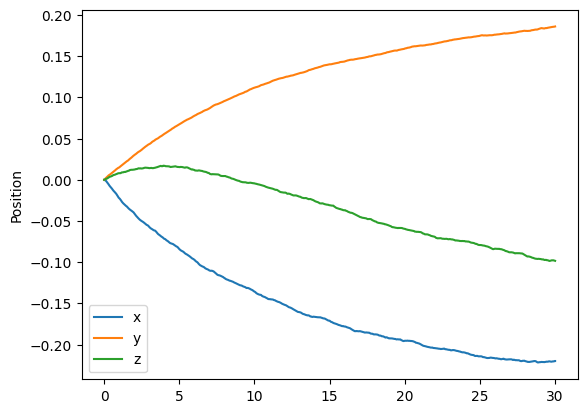

In [31]:
# @title Force torque data from misaligned plugging
# plot mj vs linear model
misaligned_sensor_data = np.array(sensor_data)

plot_actions = np.array(all_actions)

labels = ['x', 'y', 'z']
ls = 'dotted'
for i in range(3):
    color = plt.get_cmap('tab10')(i)
    plt.plot(t_vec[2:], misaligned_sensor_data[1:,i], color = color, label = labels[i-3])
plt.ylabel('Position')
plt.legend(loc = 'lower left')



f.suptitle('Force Torque Sensor: Misaligned Insertion');

Now let's test this policy in sim where we will add a constant offset to the control signal, and white noise to both the controller as well as the sensor.